In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data
data = pd.read_csv('dataset/data kalori fix.csv')
data.head()

,id,calories,proteins,name,kategori
0,1,280.0,9.2,Abon,Sedang
1,2,0.0,0.0,Agar-agar,Rendah
2,3,45.0,1.1,Akar tonjong,Rendah
3,4,37.0,4.4,Aletoge,Rendah
4,5,85.0,0.9,Alpukat,Rendah


In [22]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
id          0
calories    0
proteins    0
name        0
kategori    0
dtype: int64


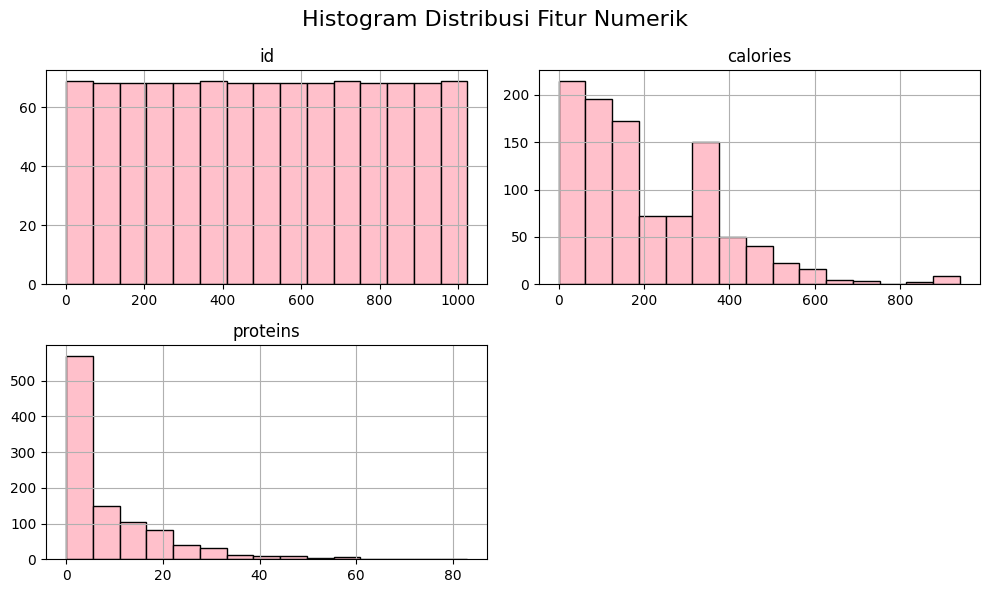

In [23]:
data.hist(bins=15, figsize=(10, 6), color='pink', edgecolor='black')
plt.suptitle("Histogram Distribusi Fitur Numerik", fontsize=16)
plt.tight_layout()
plt.grid(False) 
plt.show()

In [24]:
# Pilih fitur untuk clustering
X = data[['calories', 'proteins']]

# Normalisasi data 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Menentukan cluster optimal

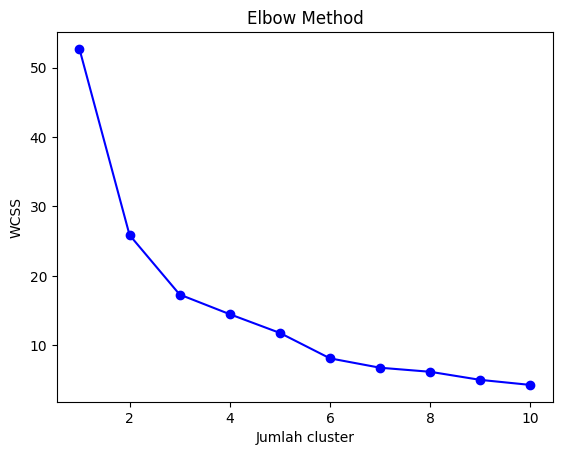

In [25]:
# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method')
plt.xlabel('Jumlah cluster')
plt.ylabel('WCSS')
plt.show()

In [26]:
# Membuat model K-Means dengan 3 cluster
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Menambahkan cluster ke dataframe
data['cluster'] = clusters

In [27]:
data.to_csv('makanan_dengan_cluster.csv', index=False)

In [28]:
inertia = kmeans.inertia_
print(f"Inertia: {inertia:.2f}")

Inertia: 17.32


### Evaluasi Model

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
silhouette_avg = silhouette_score(X_scaled, clusters)
db_index = davies_bouldin_score(X_scaled, clusters)
ch_score = calinski_harabasz_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Silhouette Score: 0.543
Davies-Bouldin Index: 0.843
Calinski-Harabasz Index: 1042.370


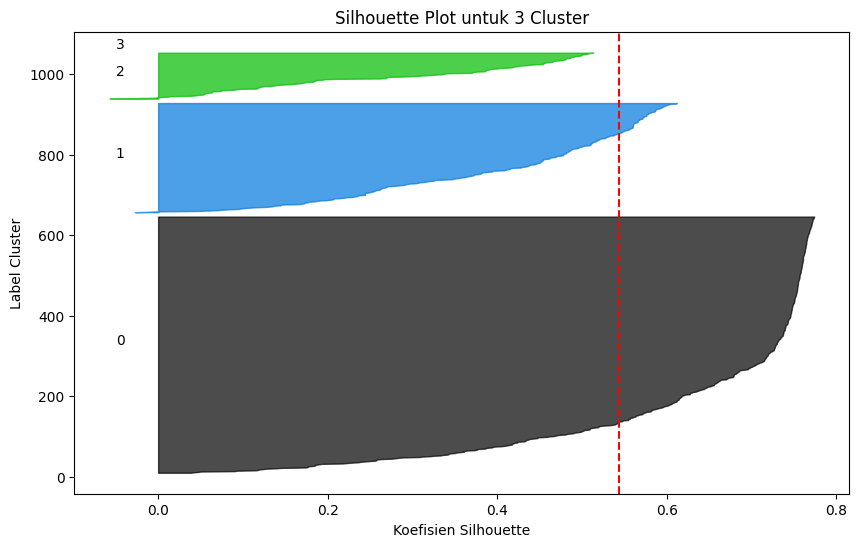

In [30]:
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.cm as cm

silhouette_values = silhouette_samples(X_scaled, clusters)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    cluster_silhouette_values = silhouette_values[clusters == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot untuk 3 Cluster")
plt.xlabel("Koefisien Silhouette")
plt.ylabel("Label Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

### tuning

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_clusters': range(2, 8),
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan']
}

kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, param_grid, cv=5, 
                         scoring=lambda estimator, X: silhouette_score(X, estimator.predict(X)))
grid_search.fit(X_scaled)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 3}


In [32]:
best_kmeans = grid_search.best_estimator_
labels = best_kmeans.predict(X_scaled)

print(f"Best silhouette score: {grid_search.best_score_:.3f}")
# Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(X_scaled, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

# Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_scaled, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Best silhouette score: 0.535
Davies-Bouldin Index: 0.843
Calinski-Harabasz Index: 1042.370


In [33]:
final_kmeans = KMeans(
    n_clusters=grid_search.best_params_['n_clusters'],
    init=grid_search.best_params_['init'],
    algorithm=grid_search.best_params_['algorithm'],
    random_state=42
)

final_clusters = final_kmeans.fit_predict(X_scaled)
data['optimized_cluster'] = final_clusters

=== Sebelum Tuning ===
Silhouette Score: 0.543
Davies-Bouldin: 0.843


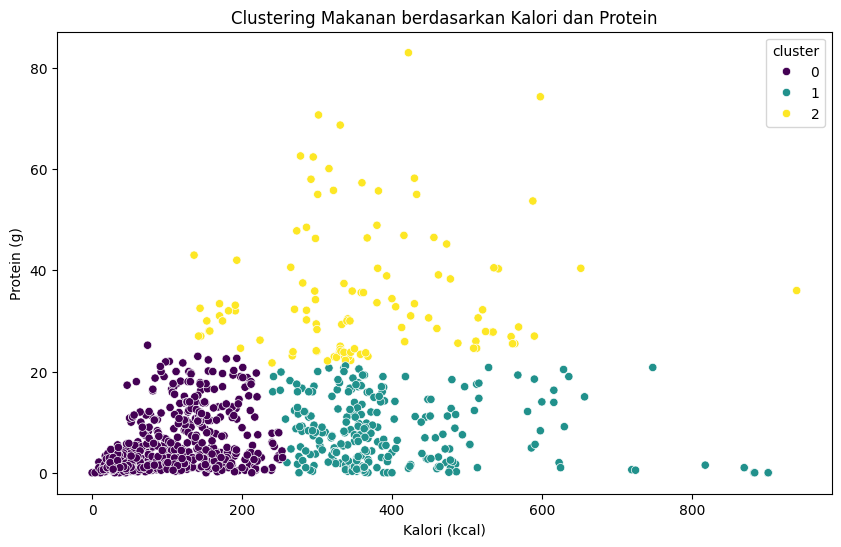

In [34]:
print("=== Sebelum Tuning ===")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, clusters):.3f}")
# Visualisasi cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='calories', y='proteins', hue='cluster', palette='viridis')
plt.title('Clustering Makanan berdasarkan Kalori dan Protein')
plt.xlabel('Kalori (kcal)')
plt.ylabel('Protein (g)')
plt.show()


=== Setelah Tuning ===
Silhouette Score: 0.543
Davies-Bouldin: 0.843


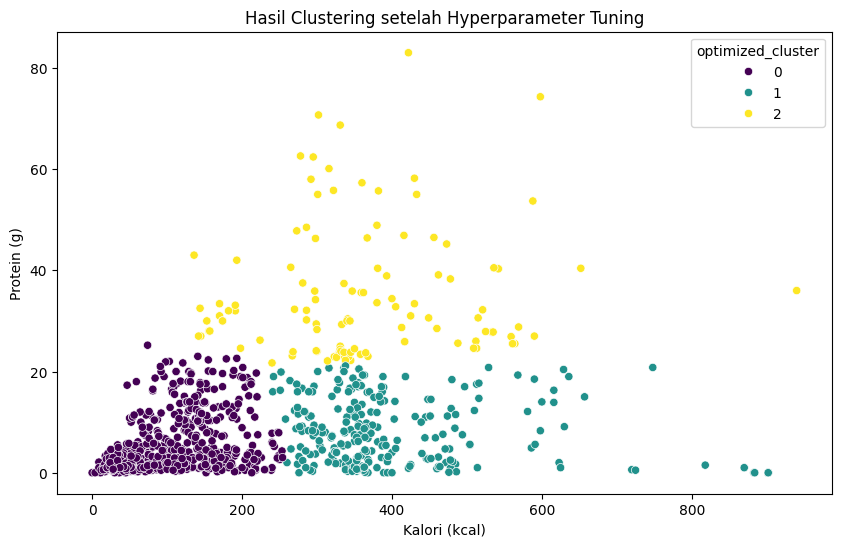

In [35]:

print("\n=== Setelah Tuning ===")
print(f"Silhouette Score: {silhouette_score(X_scaled, final_clusters):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, final_clusters):.3f}")
# Visualisasi cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='calories', y='proteins', hue='optimized_cluster', palette='viridis')
plt.title('Hasil Clustering setelah Hyperparameter Tuning')
plt.xlabel('Kalori (kcal)')
plt.ylabel('Protein (g)')
plt.show()

In [36]:
# Statistik deskriptif per cluster
cluster_stats = data.groupby('cluster')[['calories', 'proteins']].describe()
print(cluster_stats)

        calories                                                               \
           count        mean         std    min     25%    50%     75%    max   
cluster                                                                         
0          637.0  101.820565   60.537979    0.0   48.00   98.0  146.00  254.0   
1          272.0  400.147794  131.325176  241.0  331.75  357.5  439.25  902.0   
2          115.0  363.356522  131.924366  136.0  289.00  341.0  431.50  940.0   

        proteins                                                          
           count       mean        std   min     25%   50%     75%   max  
cluster                                                                   
0          637.0   5.163108   5.535529   0.0   1.200   2.9   7.300  25.2  
1          272.0   8.054044   6.388434   0.0   2.075   7.3  12.725  21.1  
2          115.0  35.082609  12.807072  21.7  25.550  30.6  40.350  83.0  


Cluster 0: makanan rendah kalori rendah protein
Cluster 1: makanan tinggi kalori rendah protein
Cluster 2: makanan sedang kalori tinggi protein

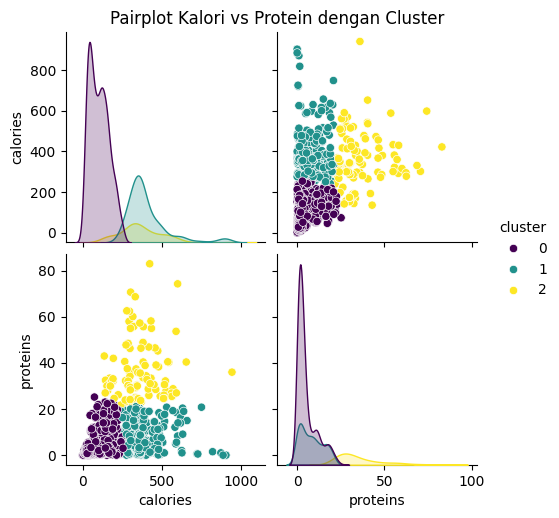

In [37]:
sns.pairplot(data, vars=['calories', 'proteins'], hue='cluster', palette='viridis')
plt.suptitle("Pairplot Kalori vs Protein dengan Cluster", y=1.02)
plt.show()

In [38]:
joblib.dump(kmeans, 'model_clustering_makanan.pkl')
joblib.dump(scaler, 'scaler_makanan.pkl')
print("modul siap digunakan")

modul siap digunakan
